# CycleGAN

Reference:
1. J. -Y. Zhu, T. Park, P. Isola and A. A. Efros, "Unpaired Image-to-Image Translation Using Cycle-Consistent Adversarial Networks," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, Italy, 2017, pp. 2242-2251, doi: 10.1109/ICCV.2017.244.

## Config

In [1]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Data

In [3]:
# number of cpu
!cat /proc/cpuinfo | grep processor

processor	: 0
processor	: 1
processor	: 2
processor	: 3
processor	: 4
processor	: 5
processor	: 6
processor	: 7
processor	: 8
processor	: 9
processor	: 10
processor	: 11
processor	: 12
processor	: 13
processor	: 14
processor	: 15


In [4]:
# dir
root = "../datasets/imgs" # "datasets"

# img size
img_height = 256
img_width = 256
channels = 3

### Dataloader

In [5]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [6]:
from torch.utils.data import Dataset
import glob, os

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.img_paths = sorted(glob.glob(img_dir + '/*.*'))  # Full paths
        self.img_names = [os.path.basename(path) for path in self.img_paths]  # File names only

    def  __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        image_name = self.img_names[index]
        if self.transform:
            image = self.transform(image)
        return image, image_name
    
    def __len__(self):
        return len(self.img_paths)

### Transformation

In [7]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    # transforms.RandomCrop((img_height, img_width)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
test_data = ImageDataset(root, transform)

test_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=4)

## Model

### Generator

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

### Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),         # (left, right, top, bottom)
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

### Initialisation

In [11]:
input_shape = (channels, img_height, img_width)
n_residual_blocks = 9 # number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks).to(device)
G_BA = GeneratorResNet(input_shape, n_residual_blocks).to(device)
D_A = Discriminator(input_shape).to(device)
D_B = Discriminator(input_shape).to(device)

In [12]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [13]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Criterion

In [14]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

## Training

In [15]:
# training
epoch = 0 # epoch to start training from
n_epochs = 200 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 100 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

### Optimizer

In [16]:
import itertools


optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

### Learning rate scheduler

In [17]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [18]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

## Test

In [19]:
def load_model(model_dir, model_name, device):
    model = torch.load(os.path.join(model_dir, model_name), map_location='cpu').to(device)

    return model

In [20]:
G_BA = load_model("outputs/model", "G_BA.pth", device)

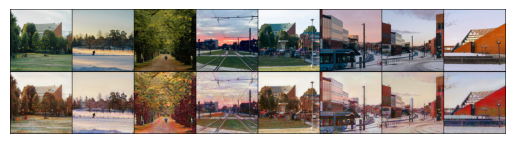

In [21]:
from matplotlib import pyplot as plt
from torchvision.utils import save_image

G_BA.eval()

output_dir = "outputs/paintings"
os.makedirs(output_dir, exist_ok=True)


for img, name in test_loader:
    img = img.to(device)

    painting = G_BA(img).detach().cpu()

    # save to files
    for idx, (image, name) in enumerate(zip(painting, name)):
        image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        file_path = os.path.join(output_dir, f"{name.split(".")[0]}.png")
        save_image(image, file_path)

    painting = make_grid(painting, nrow=8, normalize=True)
    photo = make_grid(img.cpu(), nrow=8, normalize=True)

    image_grid = torch.cat((photo, painting), 1)

    plt.imshow(image_grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

    break